In [1]:
from carbon import CarbonSimulatorUI, CarbonOrderUI, P, __version__, __date__
from math import sqrt
import numpy as np
from matplotlib import pyplot as plt
print(f"Carbon v{__version__} ({__date__})")
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CarbonSimulatorUI))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CarbonOrderUI))

Carbon v2.1-ALPHA0 (14/Dec/2022)
CarbonSimulatorUI v2.2 (8/Dec/2022)
CarbonOrderUI v1.4 (14/Dec/2022)


# Marginal Price Routing Example

The Marginal Price Routing code at the end of this notebook required a number of changes to the Carbon library. In the first few sections below we collect a number of test for those new items.

## CarbonPair related tests

In [2]:
pair = P("ETH/USDC")
assert isinstance(pair, P)
print(str(pair))
assert str(pair) == "P('ETH/USDC')"
pair2 = P.from_slashpair("  ETH / USDC")
print(pair2)
assert isinstance(pair2, P)
assert pair2.slashpair == "ETH/USDC"
pair3 = P(pair2)
assert isinstance(pair3, P)
assert pair3==pair2

P('ETH/USDC')
P('ETH/USDC')


## CarbonOrderUI general tests

In [3]:
order = CarbonOrderUI.from_prices("ETH/USDC", "ETH", 2000, 3000, 10, 10)
assert isinstance(order, CarbonOrderUI)
#print(round(order.B,10))
assert round(order.B,10) == 0.0182574186
#print(round(order.S,10))
assert round(order.S,10) == 0.0041032612
assert order.yint == 10
assert order.y == 10
assert order.pa == 2000
assert order.pb == 3000
assert order.p_marg == 2000
assert order.pa == order.py
assert order.pb == order.px
assert order.total_liquidity == (10, 'ETH')
assert round(order.p0, 10) == round(sqrt(2000*3000),10)
assert round(order.widthpc, 10) == round((3000-2000)/sqrt(2000*3000),10)
assert round(order.widthr, 10) == round(3000/2000,10)
order

CarbonOrderUI(pair=P('ETH/USDC'), tkn='ETH', B=0.018257418583505537, S=0.004103261191492361, yint=10, y=10)

In [4]:
try:
    CarbonOrderUI.from_prices("ETH/USDC", "ETH", 2000, 3000, 5, 10)
    raise RuntimeError("Should have raised exception")
except ValueError as e:
    print(e)

('y must not be bigger than yint (y={y}, yint={yint})', 5, 10)


In [5]:
try:
    CarbonOrderUI.from_prices("ETH/USDC", "ETH", 2000, 3000, -10, -10)
    raise RuntimeError("Should have raised exception")
except ValueError as e:
    print(e)

('yint must be non-negative', -10)


In [6]:
try:
    CarbonOrderUI.from_prices("ETH/USDC", "ETH", 2000, 3000, 10, -10)
    raise RuntimeError("Should have raised exception")
except ValueError as e:
    print(e)

('y must be non-negative', -10)


In [7]:
order = CarbonOrderUI.from_prices("ETH/USDC", "ETH", 3000, 2000, 10, 10)
assert order.pa == 2000
assert order.pb == 3000
order

[from_prices] exchanging pa, pb


CarbonOrderUI(pair=P('ETH/USDC'), tkn='ETH', B=0.018257418583505537, S=0.004103261191492361, yint=10, y=10)

In [8]:
orderr = CarbonOrderUI.from_prices("ETH/USDC", "USDC", 1000, 750, 10000, 10000)
assert orderr.pa == 1000
assert round(orderr.pb,6) == 750
orderr

CarbonOrderUI(pair=P('ETH/USDC'), tkn='USDC', B=27.386127875258307, S=4.236648726425486, yint=10000, y=10000)

In [9]:
assert order.p_marg_f(0) == order.p_marg
assert round(order.p_marg_f(5), 6) == 2424.492346
assert order.p_marg_f(10) == 3000

In [10]:
assert orderr.p_marg_f(0) == orderr.p_marg
assert round(orderr.p_marg_f(10000),8) == 750

In [11]:
assert order.p_marg_f(-1, raiseonerror=False) is None
assert order.p_marg_f(10.0001, raiseonerror=False) is None
assert order.p_marg_f(-1) is None
assert order.p_marg_f(10.0001) is None

In [12]:
assert orderr.p_marg_f(10001, raiseonerror=False) is None
assert orderr.p_marg_f(10001) is None

In [13]:
try:
    order.p_marg_f(-1, raiseonerror=True)
    raise RuntimeError("Should have raised exception")
except ValueError as e:
    print(e)
    assert str(e) == "('Trade size dy must be a non-negative number', -1)"

('Trade size dy must be a non-negative number', -1)


In [14]:
try:
    order.p_marg_f(10.001, raiseonerror=True)
    raise RuntimeError("Should have raised exception")
except ValueError as e:
    print(e)

('Trade size dy too big, results in y<0', 10.001, -0.0009999999999994458, 10)


In [15]:
try:
    order.p_marg_f(10001, raiseonerror=True)
    raise RuntimeError("Should have raised exception")
except ValueError as e:
    print(e)

('Trade size dy too big, results in y<0', 10001, -9991, 10)


## CarbonOrderUI tests yfromp

In [16]:
order = CarbonOrderUI.from_prices("ETH/USDC", "ETH", 2000, 3000, 10, 10)
order1 = CarbonOrderUI.from_prices("ETH/USDC", "ETH", 2000, 3000, 10, 5)
orderr = CarbonOrderUI.from_prices("ETH/USDC", "USDC", 1000, 750, 10000, 10000)

In [17]:
assert order.yfromp_f(2000) == 10
assert order.yfromp_f(3000) == 0
assert order.dyfromp_f(2000) == 0
assert order.dyfromp_f(3000) == 10

In [18]:
try:
    order1.yfromp_f(2000, raiseonerror=True)
    raise RuntimeError("Should have raised exception")
except ValueError as e:
    print(e)

('Price out of bounds (beyond marginal), hence target y > y', 10.0, 5)


In [19]:
assert orderr.yfromp_f(1000) == 10000
assert orderr.yfromp_f(750.00000001) < 1e-6
assert orderr.dyfromp_f(1000) == 0
assert round(orderr.dyfromp_f(750.0000001),5)==10000

In [20]:
for dy in np.linspace(0,10):
    yy = order.yfromp_f(order.p_marg_f(dy))
    assert round(yy - (10-dy),10) == 0
    #print (f"dy={dy}, y={yy}, 10-dy={10-dy}")

In [21]:
for dy in np.linspace(0,10):
    dy1 = order.dyfromp_f(order.p_marg_f(dy))
    assert round(dy - dy1,10) == 0
    #print (f"dy={dy}, dy1={dy1}")

In [22]:
for dy in np.linspace(0,10000):
    dy1 = orderr.dyfromp_f(orderr.p_marg_f(dy))
    assert round(dy - dy1,4) == 0
    #print (f"dy={dy}, dy1={dy1}")

## CarbonOrderUI tests dyfromdx_f and dxfromdy_f

In [23]:
help(CarbonOrderUI.dyfromdx_f)

Help on function dyfromdx_f in module carbon.carbon_order_ui:

dyfromdx_f(self, dx, checkbounds=True, raiseonerror=False)
    calculates the amount dy SOLD by the AMM to RECEIVE an amount dx
    
    :dx:            the amount of x the AMM RECEIVES (a POSITIVE number*)
    :checkbounds:   if True (default), check that dy is in the right range
    :raiseonerror:  if True, raises upon error, else return None
    :returns:       the amount dy of y the AMM SELLS (a POSITIVE number*)
    
    *when checkbounds is False then we can have dx<0, corresponding to the 
    AMM SELLing x. In this case it returns a negative number, corresponding
    to the AMM BUYing y.



In [24]:
# in order, order1 dx is a USDC number and dy is an ETH number
order = CarbonOrderUI.from_prices("ETH/USDC", "ETH", 2000, 3000, 10, 10)
order1 = CarbonOrderUI.from_prices("ETH/USDC", "ETH", 2000, 3000, 10, 5)

# in orderr dx is an ETH number and dy is a USDC number
orderr = CarbonOrderUI.from_prices("ETH/USDC", "USDC", 1000, 750, 10000, 10000)
dxeps = dyeps = 0.000001
p0 = sqrt(2000*3000)
p0r = sqrt(1000*750)
dxmax = 10*p0-dxeps
dxmaxr = 10000/p0r-dxeps
p0, p0r, dxmax, dxmaxr

(2449.489742783178, 866.0254037844386, 24494.89742683178, 11.547004383792517)

### dyfromdx_f

In [25]:
dy = order.dyfromdx_f(dxeps)
assert round(dxeps/dy,6) == 2000
dy/dxeps, dxeps/dy

(0.0004999999999954123, 2000.0000000183509)

In [26]:
dy = order.dyfromdx_f(dxmax)
assert round(dxmax/dy - p0,6) == 0
dy/dxmax, dxmax/dy, p0

(0.0004082482904669214, 2449.4897427648275, 2449.489742783178)

In [27]:
dy = order1.dyfromdx_f(dxeps)
assert dxeps/dy > 2000
assert dxeps/dy < 3000
dy/dxeps, dxeps/dy

(0.00041245747856182756, 2424.4923464276562)

In [28]:
dy = orderr.dyfromdx_f(dxeps)
assert round(dy/dxeps,4) == 1000
dy/dxeps, dxeps/dy

(999.9999866025405, 0.0010000000133974596)

In [29]:
dy = orderr.dyfromdx_f(dxmaxr)
assert round(dy/dxmaxr - p0r,4) == 0
dy/dxmaxr, dxmaxr/dy, p0r

(866.0254138325333, 0.001154700524981792, 866.0254037844386)

### dxfromdy_f

In [30]:
dx = order.dxfromdy_f(dyeps)
assert round(dx/dyeps,4) == 2000
dx/dyeps, dyeps/dx

(2000.0000367006846, 0.000499999990824829)

In [31]:
dx = order.dxfromdy_f(10)
assert round(dx/10 - p0,6) == 0
dx/10, 10/dx, p0

(2449.4897427831784, 0.000408248290463863, 2449.489742783178)

In [32]:
dx = order1.dxfromdy_f(dyeps)
assert dx/dyeps > 2000
assert dx/dyeps < 3000
dx/dyeps, dyeps/dx

(2424.4923953921457, 0.00041245747023193144)

In [33]:
dx = orderr.dxfromdy_f(dyeps)
assert round(dyeps/dx,4) == 1000
dx/dyeps, dyeps/dx

(0.0010000000000133977, 999.9999999866022)

In [34]:
dx = orderr.dxfromdy_f(10000)
assert round(10000/dx - p0r,4) == 0
dx/10000, 10000/dx, p0r

(0.0011547005383792516, 866.0254037844386, 866.0254037844386)

### xfromy_f

In [35]:
assert order.xfromy_f(order.yint) == 0
assert round(order.xfromy_f(0)- order.p0*order.yint, 10) == 0
assert order.x == 0
assert order.xfromy_f(order.y) == order.x
for i in range(10):
    #print (i)
    assert round(order.dxfromdy_f(i) - order.xfromy_f(order.y-i), 10) == 0

In [36]:
assert orderr.xfromy_f(orderr.yint) == 0
assert round(orderr.xfromy_f(0)- orderr.yint/orderr.p0, 10) == 0
assert orderr.xfromy_f(orderr.y) == orderr.x
for i in range(10):
    #print (i)
    assert round(orderr.dxfromdy_f(i*1000) - orderr.xfromy_f(orderr.y-i*1000), 10) == 0

In [37]:
assert order1.xfromy_f(order1.yint) == 0
assert round(order1.xfromy_f(0)- order.p0*order.yint, 10) == 0
assert order1.xfromy_f(order1.y) == order1.x
for i in range(5):
    #print (i)
    assert round(order1.xfromy_f(order1.y) + order1.dxfromdy_f(i) - order1.xfromy_f(order1.y-i), 10) == 0

### yfromx_f

In [38]:
assert order.yfromx_f(0) == order.yint
assert order.yfromx_f(order.xint) == 0
for i in range(10):
    #print(i)
    assert round(order.yfromx_f(order.xfromy_f(i)) - i, 10)  == 0

In [39]:
assert orderr.yfromx_f(0) == orderr.yint
assert round(orderr.yfromx_f(orderr.xint-0.00000001),4)==0
for i in range(1,10):
    #print(i)
    assert round(orderr.yfromx_f(orderr.xfromy_f(i*1000)) - i*1000, 10)  == 0

### p_eff_f

In [40]:
assert order.p_eff_f(0) == 2000
assert round(order.p_eff_f(0.000000001)-2000,3) == 0
assert round(order.p_eff_f(10) - order.p0, 6) == 0

In [41]:
p1 = order1.p_eff_f(0)
assert p1 == order1.p_marg_f(0)
p2 = order1.p_marg_f(5)
assert round(order1.p_eff_f(5) - sqrt(p1*p2),5) == 0
p1,p2, sqrt(p1*p2)

(2424.4923464074514, 3000.0, 2696.9384566990684)

In [42]:
assert orderr.p_eff_f(0) == 1000
assert round(orderr.p_eff_f(0.1)-1000,2) == 0
assert round(orderr.p_eff_f(10000) - orderr.p0, 6) == 0

### from_Qxy 

In [43]:
assert order.Q == sqrt(order.pb_raw/order.pa_raw)
assert order.Gamma == 1 - sqrt(order.Q)
print(f"Q={order.Q}, Gamma={order.Gamma}")

Q=0.816496580927726, Gamma=0.09639799639015512


In [44]:
assert order1.Q == sqrt(order1.pb_raw/order1.pa_raw)
assert order1.Gamma == 1 - sqrt(order1.Q)
print(f"Q={order1.Q}, Gamma={order1.Gamma}")

Q=0.816496580927726, Gamma=0.09639799639015512


In [45]:
assert orderr.Q == sqrt(orderr.pb_raw/orderr.pa_raw)
assert orderr.Gamma == 1 - sqrt(orderr.Q)
print(f"Q={orderr.Q}, Gamma={orderr.Gamma}")

Q=0.8660254037844387, Gamma=0.06939514089790033


In [46]:
order_ = CarbonOrderUI.from_Qxy(order.pair, order.tkn, order.Q, order.xint, order.yint, order.y)
assert round(order_.B - order.B, 10) == 0
assert round(order_.S - order.S, 10) == 0
assert round(order_.xint - order.xint, 10) == 0
assert round(order_.yint - order.yint, 10) == 0
assert round(order_.y - order.y, 10) == 0
order_

CarbonOrderUI(pair=P('ETH/USDC'), tkn='ETH', B=0.018257418583505537, S=0.004103261191492357, yint=10, y=10)

In [47]:
orderr_ = CarbonOrderUI.from_Qxy(orderr.pair, orderr.tkn, orderr.Q, orderr.xint, orderr.yint, orderr.y)
assert round(orderr_.B - orderr.B, 10) == 0
assert round(orderr_.S - orderr.S, 10) == 0
assert round(orderr_.xint - orderr.xint, 10) == 0
assert round(orderr_.yint - orderr.yint, 10) == 0
assert round(orderr_.y - orderr.y, 10) == 0
orderr_

CarbonOrderUI(pair=P('ETH/USDC'), tkn='USDC', B=27.386127875258307, S=4.236648726425486, yint=10000, y=10000)

## CarbonOrderUI charts [NOTEST]

In [48]:
order1 = CarbonOrderUI.from_prices("ETH/USDC", "ETH", 2000, 3000, 10, 10)
order2 = CarbonOrderUI.from_prices("ETH/USDC", "ETH", 2000, 3000, 10, 5)
orderr = CarbonOrderUI.from_prices("ETH/USDC", "USDC", 1000, 750, 25000, 25000)

In [49]:
ETHr = np.linspace(0,order1.yint)
USDCr = np.linspace(0,orderr.yint)

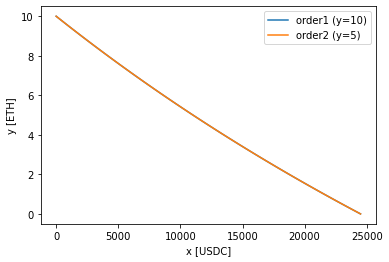

In [50]:
plt.plot([order1.xfromy_f(y) for y in ETHr], ETHr, label="order1 (y=10)")
plt.plot([order2.xfromy_f(y) for y in ETHr], ETHr, label="order2 (y=5)")
plt.ylabel("y [ETH]")
plt.xlabel("x [USDC]")
plt.legend()

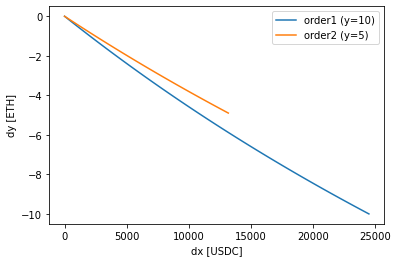

In [51]:
plt.plot([order1.dxfromdy_f(y, raiseonerror=False) for y in ETHr], -ETHr, label="order1 (y=10)")
plt.plot([order2.dxfromdy_f(y, raiseonerror=False) for y in ETHr], -ETHr, label="order2 (y=5)")
plt.ylabel("dy [ETH]")
plt.xlabel("dx [USDC]")
plt.legend()

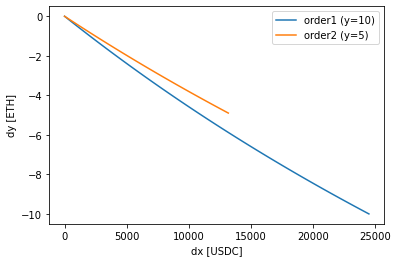

In [52]:
plt.plot([order1.dxfromdy_f(y, raiseonerror=False) for y in ETHr], -ETHr, label="order1 (y=10)")
plt.plot([order2.dxfromdy_f(y, raiseonerror=False) for y in ETHr], -ETHr, label="order2 (y=5)")
plt.ylabel("dy [ETH]")
plt.xlabel("dx [USDC]")
plt.legend()

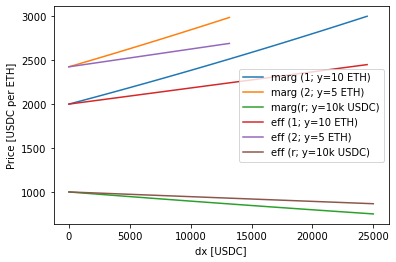

In [53]:
plt.plot(
    [order1.dxfromdy_f(dy, raiseonerror=False) for dy in ETHr], 
    [order1.p_marg_f(dy, raiseonerror=False) for dy in ETHr], 
    label="marg (1; y=10 ETH)")
plt.plot(
    [order2.dxfromdy_f(dy, raiseonerror=False) for dy in ETHr], 
    [order2.p_marg_f(dy, raiseonerror=False) for dy in ETHr], 
    label="marg (2; y=5 ETH)")
plt.plot(
    USDCr, 
    [orderr.p_marg_f(dy, raiseonerror=False) for dy in USDCr], 
    label="marg(r; y=10k USDC)")
plt.plot(
    [order1.dxfromdy_f(dy, raiseonerror=False) for dy in ETHr], 
    [order1.p_eff_f(dy, raiseonerror=False) for dy in ETHr], 
    label="eff (1; y=10 ETH)")
plt.plot(
    [order2.dxfromdy_f(dy, raiseonerror=False) for dy in ETHr], 
    [order2.p_eff_f(dy, raiseonerror=False) for dy in ETHr], 
    label="eff (2; y=5 ETH)")
plt.plot(
    USDCr, 
    [orderr.p_eff_f(dy, raiseonerror=False) for dy in USDCr], 
    label="eff (r; y=10k USDC)")
plt.ylabel("Price [USDC per ETH]")
plt.xlabel("dx [USDC]")
plt.legend(loc="center right")

## CarbonOrderUI tests goalseek

In [54]:
f = lambda x: sqrt(x)-3
print (round(CarbonOrderUI.goalseek(f,1,10), 6))
assert round(CarbonOrderUI.goalseek(f,1,10), 6) == 9

9.0


In [55]:
try:
    CarbonOrderUI.goalseek(f,10,1)
    raise RuntimeError("Should raise exception")
except ValueError as e:
    print(str(e))

('Bracketing value a must be smaller than b', 10, 1)


In [56]:
try:
    CarbonOrderUI.goalseek(f,10,20)
    raise RuntimeError("Should raise exception")
except ValueError as e:
    print(str(e))

('Sign of f(a) must be opposite of sign of f(b)', 0.16227766016837952, 1.4721359549995796, 10, 20)


## Example usage [NOTEST]

This section shows how to use yfromp-related functions for routing. This section does not create test code.

First we create a staggered list of 10 orders. Note that all those orders are only half-filled. The corresponding marginal prices are shown in the printout.

In [57]:
orders = [
    CarbonOrderUI.from_prices("ETH/USDC", "ETH", 2000+50*i, 2500+50*i, 10, 5)
    for i in range(10)
]
for o in orders:
    print(f"y={o.y} pa={round(o.px,0)} pb={round(o.py,0)} pmarg={round(o.p_marg,1)}")
margp = [o.p_marg for o in orders]
min(margp), max(margp)

y=5 pa=2500.0 pb=2000.0 pmarg=2229.1
y=5 pa=2550.0 pb=2050.0 pmarg=2279.6
y=5 pa=2600.0 pb=2100.0 pmarg=2330.0
y=5 pa=2650.0 pb=2150.0 pmarg=2380.4
y=5 pa=2700.0 pb=2200.0 pmarg=2430.8
y=5 pa=2750.0 pb=2250.0 pmarg=2481.2
y=5 pa=2800.0 pb=2300.0 pmarg=2531.6
y=5 pa=2850.0 pb=2350.0 pmarg=2581.9
y=5 pa=2900.0 pb=2400.0 pmarg=2632.3
y=5 pa=2950.0 pb=2450.0 pmarg=2682.6


(2229.1236000336485, 2682.6140015319056)

We are now looking at the dy released if we move to 2100. Spoiler: 0, because all positions are already beyond 2100.

In [58]:
[o.dyfromp_f(2100) for o in orders]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

If we go all the way to 3000 we see that all positions release their 5 ETH.

In [59]:
[o.dyfromp_f(3000) for o in orders]

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

For 2300 we see that the first two positions can still get us to 2300. They release 1.39 and 0.40 ETH respectively on the way to 2300

In [60]:
[o.dyfromp_f(2300) for o in orders]

[1.393236326565154, 0.40811287710152655, 0, 0, 0, 0, 0, 0, 0, 0]

For 2500, the first 6 positions release ETH

In [61]:
[o.dyfromp_f(2500) for o in orders]

[5.0,
 4.137019008909356,
 3.2427346404715647,
 2.3174854167487067,
 1.36159890190436,
 0.37539229489591897,
 0,
 0,
 0,
 0]

We define `dy_f` as the aggregate ETH released from all positions here

In [62]:
dy_f = lambda p: sum(o.dyfromp_f(p) for o in orders)

The corresponding USDC inflow can be computed thus

In [63]:
dx_f = lambda p: sum(o.dxfromdy_f(o.dyfromp_f(p)) for o in orders)

We can then plot the ETH release as a function of price

In [64]:
pvals = np.linspace(2000, 3000)
dyvals = [dy_f(p) for p in pvals]
dxvals = [dx_f(p) for p in pvals]

Text(0, 0.5, 'Aggregate ETH release')

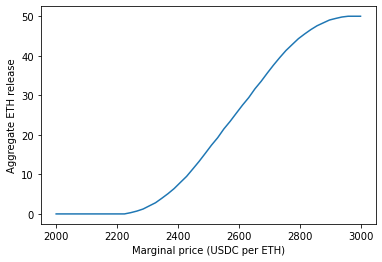

In [65]:
plt.plot(pvals, dyvals)
plt.xlabel("Marginal price (USDC per ETH)")
plt.ylabel("Aggregate ETH release")

Text(0, 0.5, 'Aggregate USDC inflow')

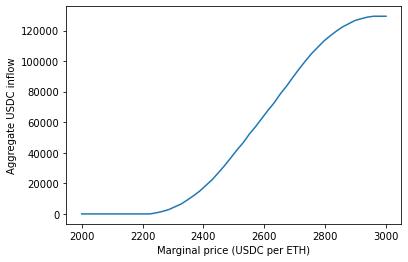

In [66]:
plt.plot(pvals, dxvals)
plt.xlabel("Marginal price (USDC per ETH)")
plt.ylabel("Aggregate USDC inflow")

Text(0, 0.5, 'Aggregate ETH release')

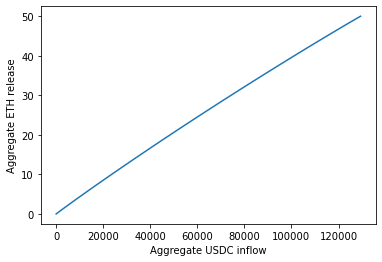

In [67]:
plt.plot(dxvals, dyvals)
plt.xlabel("Aggregate USDC inflow")
plt.ylabel("Aggregate ETH release")

Text(0, 0.5, 'Effective price (USDC per ETH)')

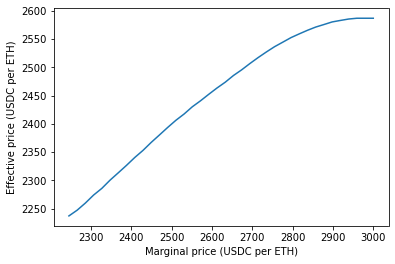

In [68]:
plt.plot(pvals, [dx/dy if dy>0 else None for dx,dy in zip(dxvals, dyvals)])
plt.xlabel("Marginal price (USDC per ETH)")
plt.ylabel("Effective price (USDC per ETH)")

Note for **Asaf**: this almost solves your "what is the price" problem if you plot it the other way round. The only issue is that here this is the marginal price after a move, so you'd have to integrate over it. We can also get the dx values the way we got the dy values (via the swap equation) but I do not have this implemented yet.

Text(0.5, 0, 'Aggregate ETH release')

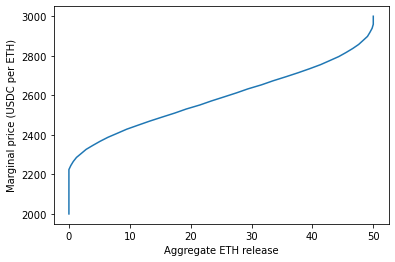

In [69]:
plt.plot(dyvals, pvals)
plt.ylabel("Marginal price (USDC per ETH)")
plt.xlabel("Aggregate ETH release")

Now this does solve your price question

Text(0, 0.5, 'Effective price (USDC per ETH)')

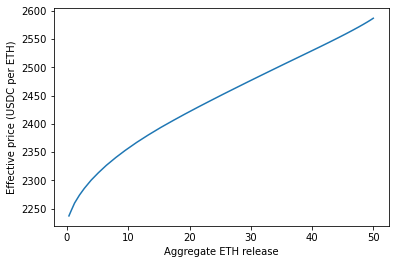

In [70]:
plt.plot(dyvals, [dx/dy if dy>0 else None for dx,dy in zip(dxvals, dyvals)])
plt.xlabel("Aggregate ETH release")
plt.ylabel("Effective price (USDC per ETH)")

Going back to the routing problem we want to solve is that we have an aggregate release, say `15`, and we want the price; this we can do with goalseek

In [71]:
p_goal = CarbonOrderUI.goalseek(lambda p: dy_f(p)-15, 2000, 3000)
p_goal

2487.0588779449463

The contribution of the positions at this price -- aka the **routing** -- is as follows

In [72]:
rl1 = [o.dyfromp_f(p_goal) for o in orders]
rl1

[4.779867109477664,
 3.909431354268376,
 3.007611565327439,
 2.074747101342123,
 1.1111663381843746,
 0.11718726278194591,
 0,
 0,
 0,
 0]

We can check that we routed indeed 15 ETH (the slight discrepancy is probably mostly related to goalseek precision)

In [73]:
sum([o.dyfromp_f(p_goal) for o in orders])

15.000010731381924

And finally we can verify this against the exact algo match

In [74]:
Sim = CarbonSimulatorUI(pair="ETH/USDC", verbose=False, raiseonerror=False)
Sim

CarbonSimulatorUI(<0 orders, 0 trades>, pair='ETH/USDC', mm='exact', xf=True)

In [75]:
for i in range(10):
    Sim.add_strategy('ETH', 10, 2000+50*i, 2500+50*i, None, None, None, None)
    # sell 5 ETH off each order to get the appropriate p_marg
    Sim.amm_sells('ETH', 5, use_positions=[i*2])
Sim.state()['orders'].query("disabled==False")

,id,pair,tkn,y_int,y,y_unit,disabled,p_start,p_end,p_marg,p_unit,lid
0,0,ETHUSDC,ETH,10.0,5.0,ETH,False,2000.0,2500.0,2229.1236,USDC per ETH,1
2,2,ETHUSDC,ETH,10.0,5.0,ETH,False,2050.0,2550.0,2279.579255,USDC per ETH,3
4,4,ETHUSDC,ETH,10.0,5.0,ETH,False,2100.0,2600.0,2330.015407,USDC per ETH,5
6,6,ETHUSDC,ETH,10.0,5.0,ETH,False,2150.0,2650.0,2380.433284,USDC per ETH,7
8,8,ETHUSDC,ETH,10.0,5.0,ETH,False,2200.0,2700.0,2430.834014,USDC per ETH,9
10,10,ETHUSDC,ETH,10.0,5.0,ETH,False,2250.0,2750.0,2481.218632,USDC per ETH,11
12,12,ETHUSDC,ETH,10.0,5.0,ETH,False,2300.0,2800.0,2531.588093,USDC per ETH,13
14,14,ETHUSDC,ETH,10.0,5.0,ETH,False,2350.0,2850.0,2581.943276,USDC per ETH,15
16,16,ETHUSDC,ETH,10.0,5.0,ETH,False,2400.0,2900.0,2632.284995,USDC per ETH,17
18,18,ETHUSDC,ETH,10.0,5.0,ETH,False,2450.0,2950.0,2682.614002,USDC per ETH,19


In [76]:
r = Sim.amm_sells('ETH', 15)['trades']
r

,uid,id,subid,note,aggr,exec,limitfail,amt1,tkn1,amt2,tkn2,pair,routeix,nroutes,price,p_unit
0,10.0,10,0,route #0,False,True,None,4.779865,ETH,11254.488784,USDC,ETHUSDC,0,1,2391.638426,USDC per ETH
0,10.1,10,1,route #2,False,True,None,3.909430,ETH,9308.587288,USDC,ETHUSDC,2,1,2391.638426,USDC per ETH
0,10.2,10,2,route #4,False,True,None,3.007610,ETH,7240.089143,USDC,ETHUSDC,4,1,2391.638426,USDC per ETH
0,10.3,10,3,route #6,False,True,None,2.074745,ETH,5048.191466,USDC,ETHUSDC,6,1,2391.638426,USDC per ETH
0,10.4,10,4,route #8,False,True,None,1.111164,ETH,2732.115287,USDC,ETHUSDC,8,1,2391.638426,USDC per ETH
0,10.5,10,5,route #10,False,True,None,0.117185,ETH,291.104415,USDC,ETHUSDC,10,1,2391.638426,USDC per ETH
0,10,10,A,AMM sells 15ETH buys 35875USDC,True,True,None,15.000000,ETH,35874.576383,USDC,ETHUSDC,"[0, 2, 4, 6, 8, 10]",6,2391.638426,USDC per ETH


Below `rl2` is the route list obtained through routing, and `rl1` the original one. We see they are extremely close.

In [77]:
rl2 = list(r.query("aggr==False")["amt1"])
rl2

[4.779865, 3.90943, 3.00761, 2.074745, 1.111164, 0.117185]

In [78]:
rl1[:len(rl2)]

[4.779867109477664,
 3.909431354268376,
 3.007611565327439,
 2.074747101342123,
 1.1111663381843746,
 0.11718726278194591]

In [79]:
[x2-x1 for x1,x2 in zip(rl1, rl2)]

[-2.1094776636587653e-06,
 -1.354268376108081e-06,
 -1.5653274387794625e-06,
 -2.1013421229731932e-06,
 -2.3381843745617914e-06,
 -2.262781945913672e-06]